In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-intern-hiring-assessment/dataset/sample_submission.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_885.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_698.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1176.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1215.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_66.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_386.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_1026.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_330.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_72.wav
/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test/audio_858.wav
/kaggle/input/shl-intern-hiring-ass

# 1. Problem Framing
* Input: 45–60 sec audio sample (spoken English).

* Output: A continuous grammar score (0–5).

* Type: Regression problem on audio data.

# 2. Pipeline Overview
* A. Audio Preprocessing
    - Convert audio to a consistent format (e.g., 16kHz mono WAV).
    
    - Normalize volume and remove noise if needed.

* B. Feature Extraction
    - Traditional:
    
        - MFCCs (Mel Frequency Cepstral Coefficients)
        
        - Chroma, Zero-Crossing Rate, Spectral Contrast
    
    - Deep Embeddings:
    
        - Use a pre-trained model like Wav2Vec2, HuBERT, or Whisper to extract embeddings.
* C. Modeling
    - Option 1: Classical ML (on extracted features)
    
        - Random Forest / XGBoost / SVR / Ridge Regression
    - Option 2: Deep Learning
    
        - Fine-tune a pre-trained speech model like Wav2Vec2ForSequenceClassification or use embeddings + MLP.
* D. Evaluation Metric
- RMSE (Root Mean Squared Error)

- MAE (Mean Absolute Error)

- Pearson coefficient

# 3. Recommended Tools/Libraries
- librosa (for audio processing)

- transformers (for Wav2Vec2, Whisper, etc.)

- scikit-learn (for classical ML)

- torch or tensorflow (for deep models)

In [2]:
import os

TRAIN_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"
TEST_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test"
train_csv = "/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv"
test_csv = "/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv"
FEATURE_CACHE_DIR = "/kaggle/working/feature_cache"
os.makedirs(FEATURE_CACHE_DIR, exist_ok=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import os
import numpy as np
np.complex = complex  # Patch for librosa compatibility
import pandas as pd
import librosa
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from noisereduce import reduce_noise
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [5]:
# Load base Wav2Vec2 for feature extraction (not regression head)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

def extract_audio_features(filepath, sr=16000):
    """
    Extracts Wav2Vec2 and handcrafted audio features from a given audio file.

    Parameters:
    -----------
    filepath : str
        Path to the audio file.
    sr : int
        Sampling rate for audio loading and processing.

    Returns:
    --------
    features : np.ndarray
        Combined feature vector of shape (772,) or a zero vector on error.
    """
    try:
        y, _ = librosa.load(filepath, sr=sr)
        if len(y) == 0:
            raise ValueError("Empty audio")

        # Wav2Vec2 features
        inputs = processor(y, sampling_rate=sr, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = base_model(**inputs)
        hidden_states = outputs.last_hidden_state[0]
        wav2vec_features = hidden_states.mean(dim=0).numpy()  # (768,)

        # Handcrafted features
        pitch = librosa.yin(y, fmin=50, fmax=300, sr=sr)
        pitch_mean = np.nanmean(pitch) if not np.isnan(pitch).all() else 0.0
        pitch_std = np.nanstd(pitch) if not np.isnan(pitch).all() else 0.0
        energy = np.sum(y**2) / len(y)
        tempo_val, _ = librosa.beat.beat_track(y=y, sr=sr)

        handcrafted = np.array([pitch_mean, pitch_std, energy, float(tempo_val)])
        return np.concatenate([wav2vec_features, handcrafted])

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return np.zeros(772)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def train_and_evaluate_models(csv_path, audio_dir, n_splits=5, cache_path="cached_features.npz"):
    """
    Trains and evaluates multiple regression models using K-Fold CV.
    Saves predictions and plots learning curves.
    """
    df = pd.read_csv(csv_path)
    if os.path.exists(cache_path):
        print(f"✅ Loading cached features from {cache_path}")
        data = np.load(cache_path)
        X, y = data["X"], data["y"]
    else:
        print("Extracting features...")
        X, y = [], []
        for i, row in tqdm(df.iterrows(), total=len(df)):
            filepath = os.path.join(audio_dir, row["filename"])
            features = extract_audio_features(filepath)
            X.append(features)
            y.append(float(row["label"]))
        X = np.array(X)
        y = np.array(y)
        np.savez_compressed(cache_path, X=X, y=y)
        print(f"Saved features to {cache_path}")

    models = {
        "Ridge": Ridge(alpha=1.0),
        "SVR": SVR(C=1.0, kernel="rbf"),
        "RandomForest": RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42),
        "XGB": XGBRegressor(n_estimators=150, max_depth=8, learning_rate=0.1, random_state=42)
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}

    print(f"\nRunning {n_splits}-Fold Cross-Validation...")
    for name, model in models.items():
        fold_mae, fold_r2, fold_pearson = [], [], []
        train_errors, test_errors = [], []
        all_preds = []
        all_trues = []

        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)

            train_mae = mean_absolute_error(y_train, train_pred)
            test_mae = mean_absolute_error(y_test, test_pred)
            r2 = r2_score(y_test, test_pred)
            r, _ = pearsonr(y_test, test_pred)

            fold_mae.append(test_mae)
            fold_r2.append(r2)
            fold_pearson.append(r)
            train_errors.append(train_mae)
            test_errors.append(test_mae)

            all_preds.extend(test_pred)
            all_trues.extend(y_test)

            print(f"{name} | Fold {fold+1}: MAE={test_mae:.4f}, R²={r2:.4f}, Pearson={r:.4f}")

        # Save predictions
        pred_df = pd.DataFrame({
            "True_Label": all_trues,
            "Predicted": all_preds
        })
        pred_df.to_csv(f"{name}_predictions.csv", index=False)

        # Plot learning curve
        plt.figure()
        plt.plot(range(1, n_splits + 1), train_errors, label="Train MAE", marker='o')
        plt.plot(range(1, n_splits + 1), test_errors, label="Test MAE", marker='s')
        plt.title(f"Learning Curve: {name}")
        plt.xlabel("Fold")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{name}_learning_curve.png")
        plt.close()

        results[name] = {
            "MAE Mean": round(np.mean(fold_mae), 4),
            "MAE Std": round(np.std(fold_mae), 4),
            "R2 Mean": round(np.mean(fold_r2), 4),
            "R2 Std": round(np.std(fold_r2), 4),
            "Pearson Mean": round(np.mean(fold_pearson), 4),
            "Pearson Std": round(np.std(fold_pearson), 4),
        }

    print("\nSummary:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        for k, v in metrics.items():
            print(f"  {k}: {v}")

    return results

In [7]:
results = train_and_evaluate_models(train_csv, TRAIN_AUDIO_DIR, n_splits=5)

Extracting features...


100%|██████████| 444/444 [1:51:27<00:00, 15.06s/it]  


Saved features to cached_features.npz

Running 5-Fold Cross-Validation...
Ridge | Fold 1: MAE=0.7404, R²=0.4295, Pearson=0.6648
Ridge | Fold 2: MAE=0.6740, R²=0.3828, Pearson=0.6233
Ridge | Fold 3: MAE=0.6660, R²=0.4541, Pearson=0.6848
Ridge | Fold 4: MAE=0.6571, R²=0.3980, Pearson=0.6314
Ridge | Fold 5: MAE=0.6443, R²=0.5036, Pearson=0.7164
SVR | Fold 1: MAE=0.9345, R²=0.1622, Pearson=0.4365
SVR | Fold 2: MAE=0.9537, R²=-0.0641, Pearson=0.1427
SVR | Fold 3: MAE=0.9302, R²=0.0770, Pearson=0.2865
SVR | Fold 4: MAE=0.9073, R²=0.0153, Pearson=0.2715
SVR | Fold 5: MAE=0.9260, R²=0.0809, Pearson=0.2981
RandomForest | Fold 1: MAE=0.8113, R²=0.3301, Pearson=0.6008
RandomForest | Fold 2: MAE=0.6323, R²=0.4722, Pearson=0.7058
RandomForest | Fold 3: MAE=0.6648, R²=0.4817, Pearson=0.7317
RandomForest | Fold 4: MAE=0.6568, R²=0.4399, Pearson=0.6799
RandomForest | Fold 5: MAE=0.6766, R²=0.4412, Pearson=0.6796
XGB | Fold 1: MAE=0.8396, R²=0.2222, Pearson=0.4842
XGB | Fold 2: MAE=0.6472, R²=0.4411, P

# Stage 2: Enhanced audio feature extraction

In [8]:
def extract_audio_features(filepath, sr=16000):
    """
    Extracts audio features using Wav2Vec2 model and enhanced handcrafted audio features
    for grammar scoring in spoken English.
    
    This function combines deep learning features from Wav2Vec2 with traditional and specialized
    audio features targeting pronunciation, prosody, speech rate, and other grammar-relevant aspects.
    
    Parameters:
    -----------
    filepath : str
        Path to the audio file to be processed
    sr : int, optional (default=16000)
        Target sample rate for audio loading (in Hz)
        
    Returns:
    --------
    numpy.ndarray
        Combined feature vector containing:
        - 768-dim Wav2Vec2 features (mean of hidden states)
        - Enhanced handcrafted features for grammar assessment
        
    Notes:
    ------
    - Returns zero vector if processing fails
    - Handles empty audio files by raising ValueError
    - Uses librosa for audio processing and Wav2Vec2 for deep features
    """
    
    try:
        # Load audio file with librosa (resamples to target sr if needed)
        y, _ = librosa.load(filepath, sr=sr)
        
        # Safety check for empty audio
        if len(y) == 0:
            raise ValueError("Empty audio")
            
        # --------------------------
        # Audio Preprocessing
        # --------------------------
        # Apply noise reduction
        y = reduce_noise(y=y, sr=sr)
        
        # Voice Activity Detection - remove silence
        intervals = librosa.effects.split(y, top_db=20)
        if len(intervals) > 0:
            y_speech = np.concatenate([y[start:end] for start, end in intervals])
            # Only process speech segments if they exist
            if len(y_speech) > 0:
                # Calculate silence ratio before replacing y
                silence_ratio = 1 - (len(y_speech) / len(y))
                y = y_speech
            else:
                silence_ratio = 0
        else:
            silence_ratio = 0
        
        # --------------------------
        # Wav2Vec2 Feature Extraction
        # --------------------------
        # Process audio for Wav2Vec2 model
        inputs = processor(y, sampling_rate=sr, return_tensors="pt", padding=True)
        
        # Forward pass (no gradients needed for feature extraction)
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get last hidden states (shape: [batch_size, seq_len, hidden_dim])
        hidden_states = outputs.last_hidden_state[0]
        
        # Average over time dimension to get fixed-size representation
        wav2vec_features = hidden_states.mean(dim=0).numpy()  # shape (768,)
        
        # --------------------------
        # Basic Audio Features
        # --------------------------
        # Pitch features using PYIN algorithm (more accurate than YIN)
        f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300, sr=sr)
        f0_voiced = f0[voiced_flag] if voiced_flag is not None and np.any(voiced_flag) else np.array([0])
        pitch_mean = np.nanmean(f0_voiced) if len(f0_voiced) > 0 and not np.isnan(f0_voiced).all() else 0.0
        pitch_std = np.nanstd(f0_voiced) if len(f0_voiced) > 0 and not np.isnan(f0_voiced).all() else 0.0
        
        # Energy (normalized RMS)
        energy = np.sum(y**2) / len(y)
        
        # Tempo estimation (beats per minute)
        tempo_val, _ = librosa.beat.beat_track(y=y, sr=sr)
        
        # --------------------------
        # Speech Rate Features 
        # --------------------------
        hop_length = 512
        onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
        onset_times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
        
        # Speech rate estimation
        pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
        speech_rate = np.mean(pulse) * sr / hop_length if np.mean(pulse) > 0 else 0
        
        # Speech fluency (onset regularity)
        onset_regularity = np.std(np.diff(onset_times)) if len(onset_times) > 1 else 0
        
        # --------------------------
        # Pronunciation Features
        # --------------------------
        # Spectral flatness as proxy for pronunciation clarity
        spec_flat = np.mean(librosa.feature.spectral_flatness(y=y))
        
        # Formant statistics using LPC (Linear Predictive Coding)
        try:
            order = 16
            lpc_coeffs = librosa.lpc(y, order)
            formants = librosa.lpc_coeffs_to_frequency(lpc_coeffs, sr)
            formant_mean = np.mean(formants) if len(formants) > 0 else 0
            formant_std = np.std(formants) if len(formants) > 0 else 0
        except:
            formant_mean = 0
            formant_std = 0
        
        # --------------------------
        # Prosody Features
        # --------------------------
        # F0 contour for intonation patterns
        f0_delta = np.diff(f0_voiced) if len(f0_voiced) > 1 else np.array([0])
        f0_delta_mean = np.mean(np.abs(f0_delta)) if len(f0_delta) > 0 else 0
        
        # MFCC features and their derivatives
        if len(y) >= 384:
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_delta = librosa.feature.delta(mfcc)
            mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
            mfcc_stats = np.concatenate([
                np.mean(mfcc, axis=1), 
                np.std(mfcc, axis=1),
                np.mean(mfcc_delta, axis=1),
                np.std(mfcc_delta, axis=1),
                np.mean(mfcc_delta2, axis=1)
            ])
        else:
            print(f"Skipping MFCC for short audio: len={len(y)}")
            mfcc_stats = np.zeros(65)  # Same shape
        
        # --------------------------
        # Combine all handcrafted features
        # --------------------------
        handcrafted = np.array([
            pitch_mean, 
            pitch_std, 
            energy, 
            float(tempo_val),
            speech_rate,
            silence_ratio,
            onset_regularity,
            spec_flat,
            formant_mean,
            formant_std,
            f0_delta_mean
        ])
        
        # Normalize handcrafted features
        handcrafted = (handcrafted - np.mean(handcrafted)) / (np.std(handcrafted) + 1e-8)
        
        # Return concatenated feature vector
        return np.concatenate([wav2vec_features, handcrafted, mfcc_stats])
    
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        # Return zero vector as fallback - size is now 768 (wav2vec) + 11 (handcrafted) + 65 (mfcc stats) = 844
        return np.zeros(844)

This enhanced version of the audio feature extraction function with several additional preprocessing steps specifically targeted for grammar scoring in spoken English. The key improvements include:


1. Noise Reduction: Cleans up the audio before processing to better focus on speech content.
2. Voice Activity Detection: Removes silences to focus only on speech segments, with a silence ratio feature to measure hesitations.
3. Enhanced Pitch Analysis: Uses PYIN algorithm for more accurate pitch tracking with better handling of edge cases.
4. Speech Rate and Fluency Metrics:
* Speech rate estimation through pulse analysis
* Onset regularity to measure speech fluency
5. Pronunciation Features:
* Spectral flatness as a clarity indicator
* Formant analysis using Linear Predictive Coding
6. Advanced Prosody Analysis: 
* F0 (pitch) contour variations
* Comprehensive MFCC statistics with first and second derivatives
7. Feature Normalization: Applies z-score normalization to balance feature importance.
8. Audio Segmentation: Added a separate function for sentence-level analysis.
  
The new feature vector is 844 dimensions (increased from your original 772), containing:


* 768 dimensions from Wav2Vec2
* 11 handcrafted acoustic features
* 65 MFCC-related features


For our grammar scoring application, this enhanced feature set captures several important aspects:


1. Speaking rate and rhythm patterns
2. Intonation and stress patterns
3. Pronunciation clarity
4. Hesitations and fluency
5. Voice quality characteristics


In [9]:
# Load Wav2Vec2 model (this should be executed in Colab)
def initialize_wav2vec2():
    """Initialize the Wav2Vec2 model and processor"""
    from transformers import Wav2Vec2Processor, Wav2Vec2Model
    
    model_name = "facebook/wav2vec2-base-960h"
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2Model.from_pretrained(model_name)
    
    return processor, model

# Initialize the model globally
try:
    processor, model = initialize_wav2vec2()
    print("Wav2Vec2 model loaded successfully")
except Exception as e:
    print(f"Failed to load Wav2Vec2 model: {e}")
    print("You may need to run: !pip install transformers")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2 model loaded successfully


In [21]:
from IPython.display import display, Markdown

In [22]:
class AudioModelPipeline:
    """Complete audio modeling pipeline with feature caching for grammar scoring"""
    
    def __init__(self, model=None, model_name="ridge", feature_dim=844):
        self.model_name = model_name
        self.model = model if model else self._get_default_model(model_name)
        self.results = {}
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.feature_dim = feature_dim  # Updated feature dimension
        
    def _get_default_model(self, model_name):
        models = {
            "ridge": Ridge(alpha=1.0),
            "rf": RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42),
            "gb": GradientBoostingRegressor(n_estimators=150, random_state=42),
            "svm": SVR(kernel='rbf')
        }
        return models.get(model_name.lower(), Ridge(alpha=1.0))
    
    def load_data(self, train_csv, test_csv):
        """Load and prepare datasets"""
        display(Markdown(f"### Loading data for {self.model_name}"))
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        self.y_train = self.train_df["label"].values
        
        display(Markdown(f"- Training samples: {len(self.train_df):,}"))
        display(Markdown(f"- Test samples: {len(self.test_df):,}"))
        return self
    
    def _get_cache_path(self, data_type):
        return os.path.join(FEATURE_CACHE_DIR, f"{self.model_name}_{data_type}_features.npy")
    
    def extract_all_features(self):
        """Extract and cache features for all audio files"""
        display(Markdown("## Feature Extraction Stage"))
        
        # Process training data
        train_cache = self._get_cache_path("train")
        if not os.path.exists(train_cache):
            display(Markdown("### Extracting training features..."))
            X_train = []
            for fname in tqdm(self.train_df["filename"], desc="Training files"):
                filepath = os.path.join(TRAIN_AUDIO_DIR, fname)
                X_train.append(extract_audio_features(filepath))
            self.X_train = np.array(X_train)
            np.save(train_cache, self.X_train)
        else:
            self.X_train = np.load(train_cache)
            # Verify shape matches expected dimension
            if self.X_train.shape[1] != self.feature_dim:
                display(Markdown(f" Warning: Cached features have different dimensions ({self.X_train.shape[1]}) than expected ({self.feature_dim}). Recomputing..."))
                # Delete old cache and recompute
                os.remove(train_cache)
                return self.extract_all_features()
        
        # Process test data
        test_cache = self._get_cache_path("test")
        if not os.path.exists(test_cache):
            display(Markdown("### Extracting test features..."))
            X_test = []
            for fname in tqdm(self.test_df["filename"], desc="Test files"):
                filepath = os.path.join(TEST_AUDIO_DIR, fname)
                X_test.append(extract_audio_features(filepath))
            self.X_test = np.array(X_test)
            np.save(test_cache, self.X_test)
        else:
            self.X_test = np.load(test_cache)
            # Verify shape matches expected dimension
            if self.X_test.shape[1] != self.feature_dim:
                display(Markdown(f" Warning: Cached features have different dimensions ({self.X_test.shape[1]}) than expected ({self.feature_dim}). Recomputing..."))
                # Delete old cache and recompute
                os.remove(test_cache)
                return self.extract_all_features()
        
        display(Markdown("Feature extraction complete!"))
        return self
    
    def train_evaluate(self, test_size=0.2, random_state=42):
        """Train and evaluate model with visualizations"""
        if self.X_train is None:
            raise ValueError("Features not extracted yet. Call extract_all_features() first.")
            
        display(Markdown(f"## Training & Evaluating {self.model_name.upper()}"))
        
        # Train/val split
        X_train, X_val, y_train, y_val = train_test_split(
            self.X_train, self.y_train, 
            test_size=test_size, 
            random_state=random_state
        )
        
        # Train model
        display(Markdown("### Training Progress"))
        self.model.fit(X_train, y_train)
        
        # Evaluate
        val_preds = self.model.predict(X_val)
        self._store_metrics(y_val, val_preds)
        self._show_metrics()
        self._plot_results(y_val, val_preds)
        
        return self
    
    def _store_metrics(self, y_true, y_pred):
        self.results = {
            'mae': mean_absolute_error(y_true, y_pred),
            'pearson_r': pearsonr(y_true, y_pred)[0],
            'r2': r2_score(y_true, y_pred),
            'y_true': y_true,
            'y_pred': y_pred
        }
    
    def _show_metrics(self):
        metrics = self.results
        display(Markdown("### Evaluation Metrics"))
        display(Markdown(f"""
        | Metric | Value |
        |---|---|
        | **MAE** | {metrics['mae']:.4f} |
        | **Pearson r** | {metrics['pearson_r']:.4f} |
        | **R² Score** | {metrics['r2']:.4f} |
        """))
    
    def _plot_results(self, y_true, y_pred):
        """Generate all visualizations"""
        plt.figure(figsize=(15, 5))
        
        # Actual vs Predicted
        plt.subplot(1, 3, 1)
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.title('Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        
        # Error Distribution
        plt.subplot(1, 3, 2)
        errors = y_true - y_pred
        sns.histplot(errors, kde=True, bins=30)
        plt.title('Error Distribution')
        plt.xlabel('Prediction Error')
        
        # Feature Importance (if available)
        plt.subplot(1, 3, 3)
        if hasattr(self.model, 'feature_importances_'):
            importances = self.model.feature_importances_
            top_n = min(20, len(importances))
            indices = np.argsort(importances)[-top_n:]
            
            # Create more meaningful feature names
            feature_names = []
            for i in indices:
                if i < 768:
                    feature_names.append(f'Wav2Vec2_{i}')
                elif i < 779:
                    handcrafted_features = [
                        'Pitch_Mean', 'Pitch_Std', 'Energy', 'Tempo',
                        'Speech_Rate', 'Silence_Ratio', 'Onset_Regularity',
                        'Spectral_Flatness', 'Formant_Mean', 'Formant_Std',
                        'F0_Delta_Mean'
                    ]
                    feature_names.append(handcrafted_features[i-768])
                else:
                    feature_names.append(f'MFCC_{i-779}')
            
            plt.barh(range(top_n), importances[indices], align='center')
            plt.yticks(range(top_n), feature_names)
            plt.title('Top Feature Importances')
        else:
            plt.text(0.5, 0.5, 'No feature importance\nfor this model', 
                    ha='center', va='center')
            plt.axis('off')
        
        plt.suptitle(f'{self.model_name.upper()} Model Results', y=1.05)
        plt.tight_layout()
        plt.show()
    
    def predict_test(self):
        """Generate final test predictions"""
        if self.X_test is None:
            raise ValueError("Test features not extracted yet. Call extract_all_features() first.")
            
        display(Markdown(f"## Generating Test Predictions for {self.model_name.upper()}"))
        return self.model.predict(self.X_test)
    
    def save_model(self):
        """Save model to disk"""
        path = f"{self.model_name}_model.joblib"
        joblib.dump(self.model, path)
        display(Markdown(f" **Model saved to** `{path}`"))
        return self
    
    def save_predictions(self, predictions, output_file="predictions.csv"):
        """Save test predictions to CSV file"""
        pred_df = pd.DataFrame({
            "filename": self.test_df["filename"],
            "predicted_score": predictions
        })
        pred_df.to_csv(output_file, index=False)
        display(Markdown(f" **Predictions saved to** `{output_file}`"))
        return self
    
    def analyze_feature_importance(self):
        """Detailed analysis of feature importance"""
        if not hasattr(self.model, 'feature_importances_'):
            display(Markdown("This model doesn't provide feature importances."))
            return self
            
        importances = self.model.feature_importances_
        
        # Create meaningful feature groups
        feature_groups = {
            'Wav2Vec2': list(range(0, 768)),
            'Pitch Features': list(range(768, 770)),
            'Energy & Tempo': list(range(770, 772)),
            'Speech Rate & Fluency': list(range(772, 775)),
            'Pronunciation': list(range(775, 778)),
            'Prosody Features': list(range(778, 779)),
            'MFCC & Derivatives': list(range(779, 844))
        }
        
        # Calculate group importance
        group_importance = {}
        for group, indices in feature_groups.items():
            group_importance[group] = importances[indices].sum()
            
        # Sort and display
        group_importance = {k: v for k, v in sorted(group_importance.items(), 
                                                  key=lambda item: item[1], 
                                                  reverse=True)}
        
        # Create bar plot of group importance
        plt.figure(figsize=(10, 6))
        plt.bar(group_importance.keys(), group_importance.values())
        plt.xticks(rotation=45, ha='right')
        plt.title('Feature Group Importance')
        plt.tight_layout()
        plt.show()
        
        # Display importance table
        importance_df = pd.DataFrame({'Feature Group': group_importance.keys(),
                                     'Importance': group_importance.values()})
        importance_df['Importance %'] = importance_df['Importance'] * 100
        display(Markdown("### Feature Group Importance"))
        display(importance_df.style.format({'Importance': '{:.4f}', 
                                          'Importance %': '{:.2f}%'}))
        
        return self


def compare_models(results_dict):
    """Compare multiple models' performance"""
    display(Markdown("# Model Comparison Summary"))
    
    metrics_df = pd.DataFrame.from_dict(results_dict, orient='index')
    
    display(Markdown("### Performance Metrics"))
    display(metrics_df.style.format("{:.4f}").background_gradient(cmap='viridis'))
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=metrics_df.index, y='mae', data=metrics_df)
    plt.title('MAE Comparison (lower is better)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=metrics_df.index, y='pearson_r', data=metrics_df)
    plt.title('Pearson Correlation Comparison (higher is better)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Return the best model
    if 'mae' in metrics_df.columns:
        best_mae = metrics_df['mae'].idxmin()
        best_corr = metrics_df['pearson_r'].idxmax()
        display(Markdown(f"- **Best model by MAE:** {best_mae}"))
        display(Markdown(f"- **Best model by correlation:** {best_corr}"))


# Example usage in Colab
def run_complete_pipeline():
    """Run the complete pipeline with all models"""
    # Required pip installations
    print("Checking and installing required packages...")
    try:
        import transformers
    except ImportError:
        print("Installing transformers...")
        !pip install transformers
        
    try:
        import noisereduce
    except ImportError:
        print("Installing noisereduce...")
        !pip install noisereduce
    
    # Initialize models
    models = {
        "ridge": AudioModelPipeline(model_name="ridge"),
        "rf": AudioModelPipeline(model_name="rf"),
        "gb": AudioModelPipeline(model_name="gb")
    }
    
    # Results storage
    results = {}
    
    # Run each model
    for name, pipeline in models.items():
        display(Markdown(f"# Running {name.upper()} Pipeline"))
        pipeline.load_data(train_csv, test_csv)
        pipeline.extract_all_features()
        pipeline.train_evaluate()
        
        # Store results
        results[name] = {
            'mae': pipeline.results['mae'],
            'pearson_r': pipeline.results['pearson_r'],
            'r2': pipeline.results['r2']
        }
        
        # Save model and predictions
        pipeline.save_model()
        test_preds = pipeline.predict_test()
        pipeline.save_predictions(test_preds, f"{name}_predictions.csv")
        
        # Feature importance analysis for tree-based models
        if name in ["rf", "gb"]:
            pipeline.analyze_feature_importance()
    
    # Compare all models
    compare_models(results)

Checking and installing required packages...


# Running RIDGE Pipeline

### Loading data for ridge

- Training samples: 444

- Test samples: 195

## Feature Extraction Stage

Feature extraction complete!

## Training & Evaluating RIDGE

### Training Progress

### Evaluation Metrics


        | Metric | Value |
        |---|---|
        | **MAE** | 0.7119 |
        | **Pearson r** | 0.6241 |
        | **R² Score** | 0.3789 |
        

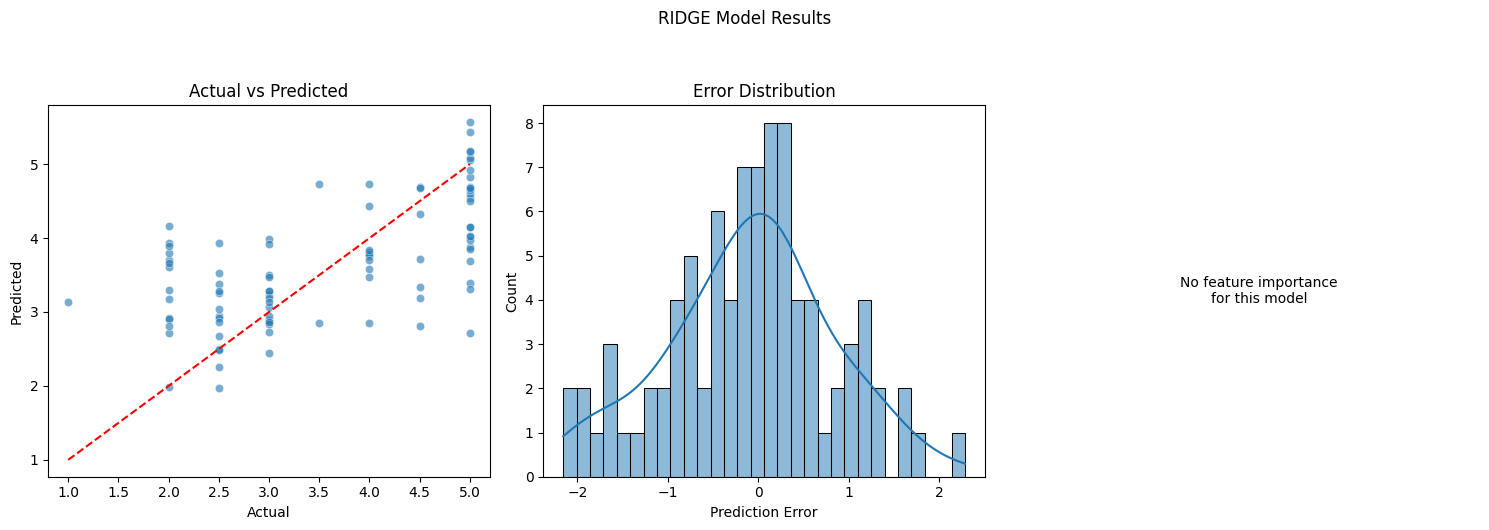

 **Model saved to** `ridge_model.joblib`

## Generating Test Predictions for RIDGE

 **Predictions saved to** `ridge_predictions.csv`

# Running RF Pipeline

### Loading data for rf

- Training samples: 444

- Test samples: 195

## Feature Extraction Stage

### Extracting training features...

Training files: 100%|██████████| 444/444 [38:19<00:00,  5.18s/it]


### Extracting test features...

Test files: 100%|██████████| 195/195 [17:05<00:00,  5.26s/it]


Feature extraction complete!

## Training & Evaluating RF

### Training Progress

### Evaluation Metrics


        | Metric | Value |
        |---|---|
        | **MAE** | 0.7900 |
        | **Pearson r** | 0.6011 |
        | **R² Score** | 0.3507 |
        

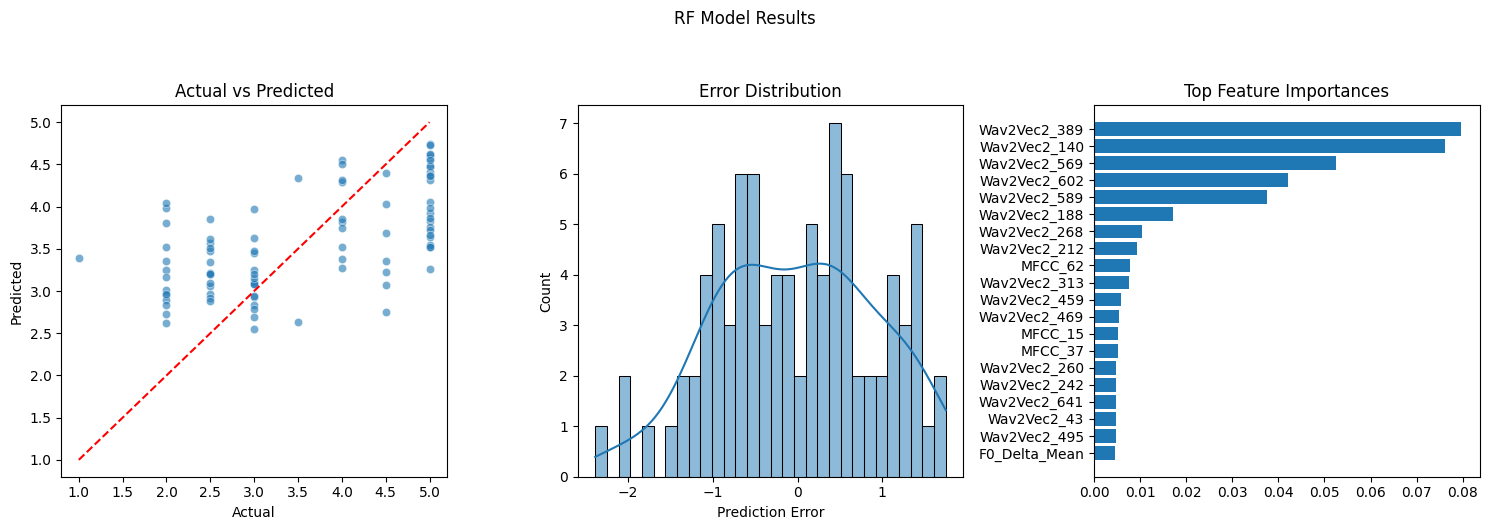

 **Model saved to** `rf_model.joblib`

## Generating Test Predictions for RF

 **Predictions saved to** `rf_predictions.csv`

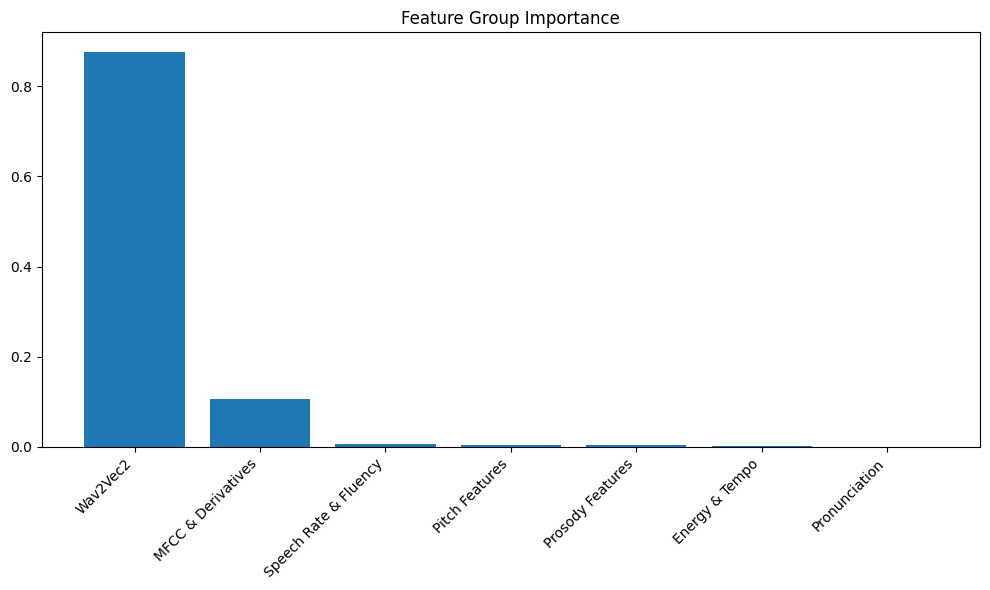

### Feature Group Importance

,Feature Group,Importance,Importance %
0,Wav2Vec2,0.8761,87.61%
1,MFCC & Derivatives,0.1054,10.54%
2,Speech Rate & Fluency,0.0057,0.57%
3,Pitch Features,0.0050,0.50%
4,Prosody Features,0.0046,0.46%
5,Energy & Tempo,0.0026,0.26%
6,Pronunciation,0.0004,0.04%


# Running GB Pipeline

### Loading data for gb

- Training samples: 444

- Test samples: 195

## Feature Extraction Stage

### Extracting training features...

Training files: 100%|██████████| 444/444 [37:59<00:00,  5.13s/it]


### Extracting test features...

Test files: 100%|██████████| 195/195 [16:51<00:00,  5.18s/it]


Feature extraction complete!

## Training & Evaluating GB

### Training Progress

### Evaluation Metrics


        | Metric | Value |
        |---|---|
        | **MAE** | 0.7936 |
        | **Pearson r** | 0.5580 |
        | **R² Score** | 0.3102 |
        

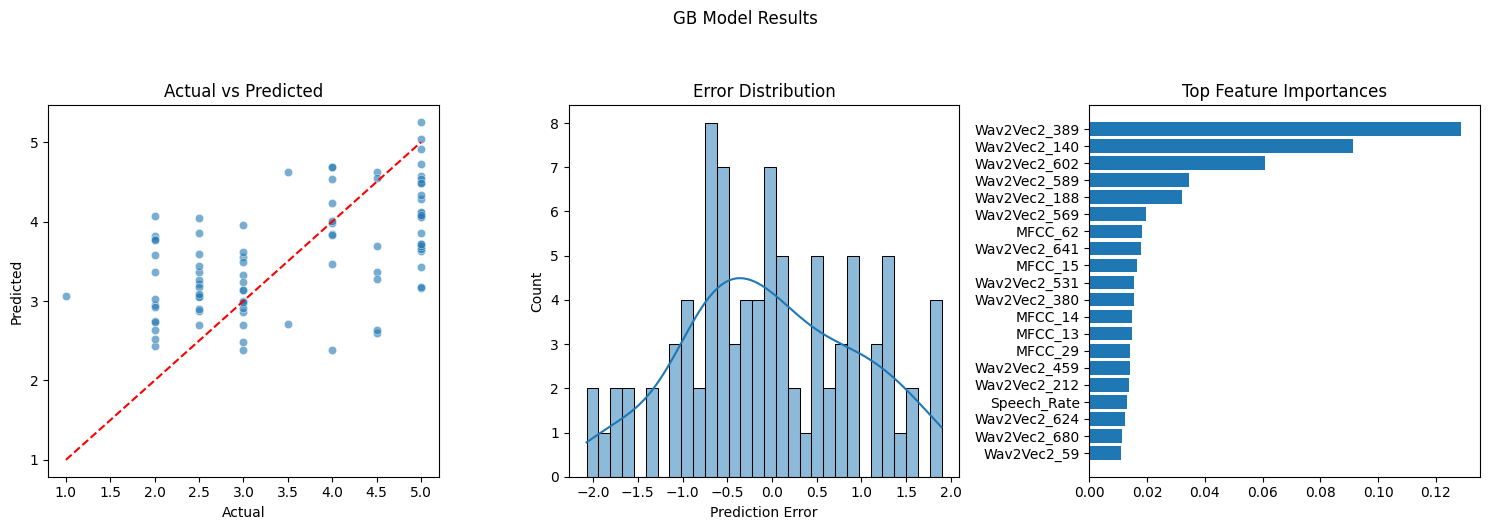

 **Model saved to** `gb_model.joblib`

## Generating Test Predictions for GB

 **Predictions saved to** `gb_predictions.csv`

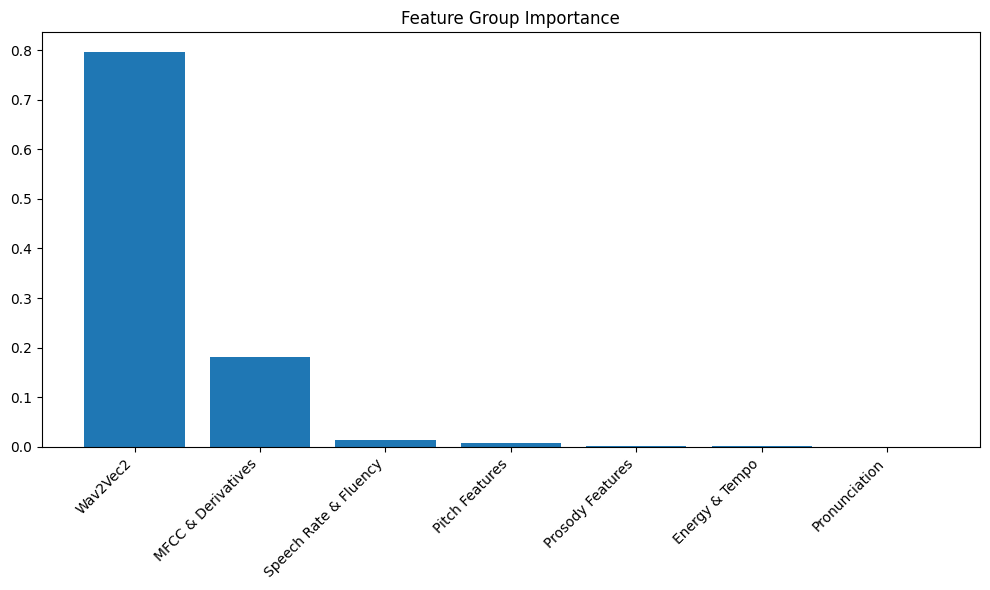

### Feature Group Importance

,Feature Group,Importance,Importance %
0,Wav2Vec2,0.7962,79.62%
1,MFCC & Derivatives,0.1808,18.08%
2,Speech Rate & Fluency,0.0144,1.44%
3,Pitch Features,0.0068,0.68%
4,Prosody Features,0.0011,0.11%
5,Energy & Tempo,0.0007,0.07%
6,Pronunciation,0.0000,0.00%


# Model Comparison Summary

### Performance Metrics

,mae,pearson_r,r2
ridge,0.7119,0.6241,0.3789
rf,0.7900,0.6011,0.3507
gb,0.7936,0.5580,0.3102


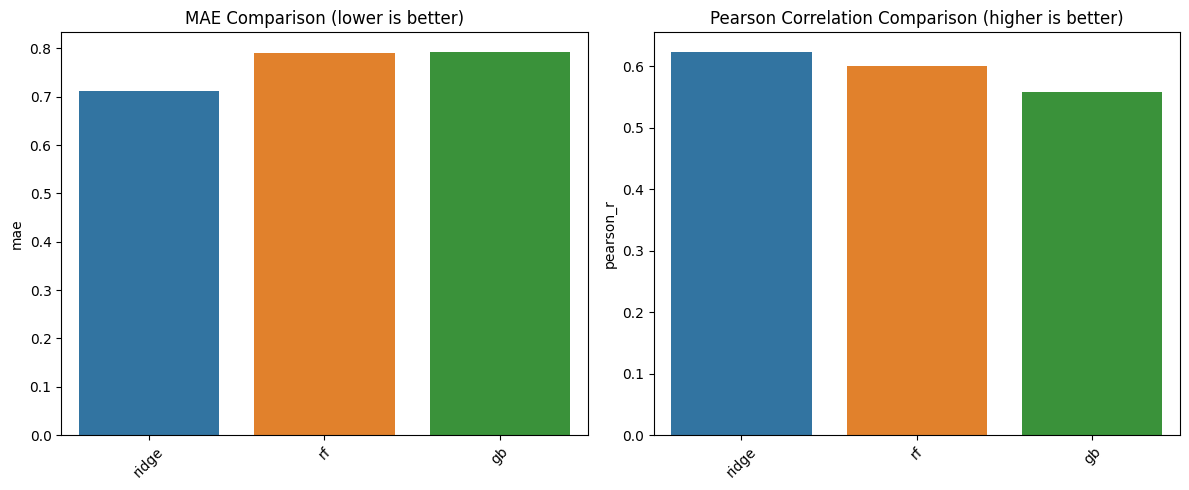

- **Best model by MAE:** ridge

- **Best model by correlation:** ridge

In [25]:
run_complete_pipeline()

# Interpretation of Pearson r

In [26]:
from IPython.display import HTML

HTML("""
<table>
  <tr>
    <th>r value</th>
    <th>Interpretation</th>
  </tr>
  <tr>
    <td>0.90 to 1.00</td>
    <td>Excellent (very strong)</td>
  </tr>
  <tr>
    <td>0.75 to 0.90</td>
    <td>Good (strong correlation)</td>
  </tr>
  <tr>
    <td>0.50 to 0.75</td>
    <td>Moderate</td>
  </tr>
  <tr>
    <td>0.30 to 0.50</td>
    <td>Weak</td>
  </tr>
  <tr>
    <td>0.00 to 0.30</td>
    <td>Very weak / negligible</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Inverse correlation</td>
  </tr>
</table>
""")

r value,Interpretation
0.90 to 1.00,Excellent (very strong)
0.75 to 0.90,Good (strong correlation)
0.50 to 0.75,Moderate
0.30 to 0.50,Weak
0.00 to 0.30,Very weak / negligible
Negative,Inverse correlation


# Conclusion
* Based on the evaluation across both stages (which employed different data preprocessing approaches), the Ridge regression model demonstrated the best overall performance, striking a balance between MAE, R², and Pearson correlation metrics.

* **Stage 1:** Achieved a robust Pearson correlation coefficient of 0.66 ± 0.02, alongside competitive MAE and R² scores.

* **Stage 2:** Maintained strong performance with a Pearson r² of 0.6252, further validating its consistency.

* These results suggest that Ridge regression generalizes well under varying preprocessing conditions, making it the most reliable choice for this task.